(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from datetime import datetime

In [125]:
# import physiobank ecg data
data_physionet = pd.read_csv('./ECG_data/physionet/ecg_id_01_1.csv', sep=",", header=2)
data_physionet.columns = ['time', 'ECG I', 'ECG I filtered']

In [3]:
t_max = 20 # s
len_series = len(data_physionet['ECG I'])
sample_frequency = len_series / t_max
t = np.linspace(0, t_max, len_series)

<IPython.core.display.Javascript object>


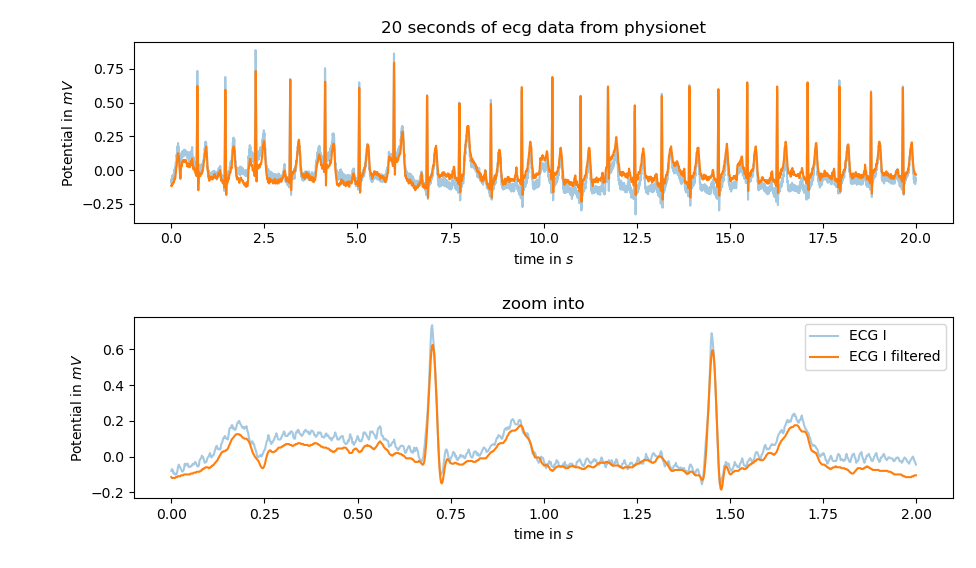

In [4]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.title('20 seconds of ecg data from physionet')
plt.plot(t, data_physionet['ECG I'], alpha=.4, label='ECG I')
plt.plot(t, data_physionet['ECG I filtered'], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(2, 1, 2)
plt.title('zoom into')
plt.plot(t[:1000], data_physionet['ECG I'][:1000], alpha=.4, label='ECG I')
plt.plot(t[:1000], data_physionet['ECG I filtered'][:1000], label='ECG I filtered')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.legend()
plt.tight_layout()
plt.show()

The starting value and the ending value of the above series by PhysioBank differ non neglectable.

In [126]:
print(data_physionet['ECG I filtered'][0] - data_physionet['ECG I filtered'][len(data_physionet['ECG I filtered'])-1])

-0.08


For this reason, to assure periodicity, the time series is cut at one end, where $s[0] = S[-1]$:

In [129]:
# original time series
series_np = np.array(data_physionet['ECG I filtered'])
print('validation before cut:', series_np[0] == series_np[-1])

# these are the points where the periodical condition is true
# we cut at the last possible point
o = np.where(series_np == series_np[0])
series_np_cut = series_np[0:o[0][-1] + 1]

# validating cut
print('validation after cut:', series_np_cut[0] == series_np_cut[0])

validation before cut: False
validation after cut: True


# Fourier analysis
Examining to obtain the base frequency $\omega_0$ of the signal. Since the signal is periodic and shows a noticable peak ata the R-waves, the base frequency must show a high amplitude in the fourier transform. From the base frequency one can receive the period $T$ of the signal via $\omega_0=\frac{2\pi}{T}$.

In [6]:
sp = np.fft.rfft(data_physionet['ECG I filtered'])
freq = np.fft.rfftfreq(t.shape[-1])
freq = freq * 499.95

<IPython.core.display.Javascript object>


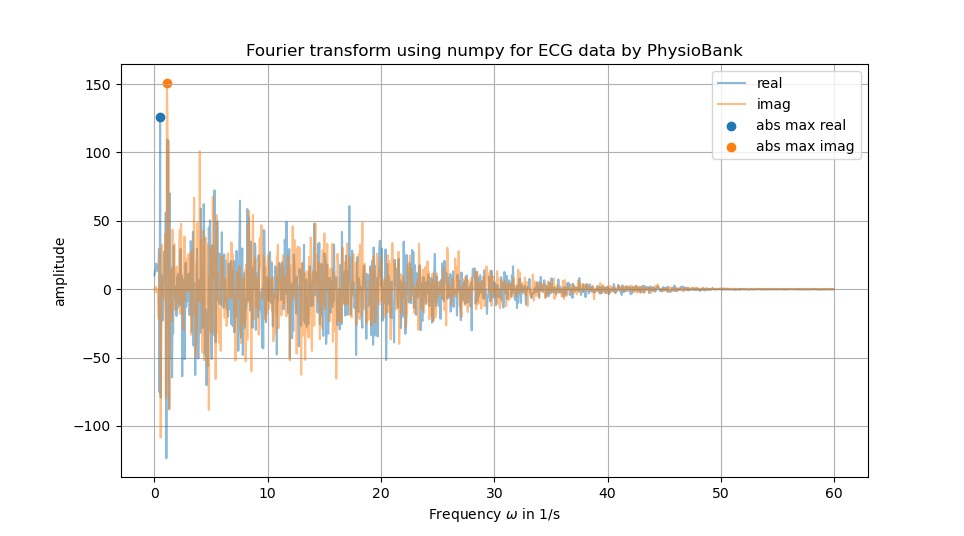

In [7]:
%matplotlib notebook

max_value = 1200

plt.plot(freq[:max_value], sp.real[:max_value], alpha=.5, label='real')
plt.plot(freq[:max_value], sp.imag[:max_value], alpha=.5, label='imag')

m_real = max(abs(sp.real))
m_r_index = np.where(abs(sp.real) == m_real)
m_real = - m_real if sp.real[m_r_index] < 0 else m_real
f_real = freq[m_r_index]
plt.scatter(f_real, m_real, label='abs max real')
m_imag = max(abs(sp.imag))
m_i_index = np.where(abs(sp.imag) == m_imag)
m_imag = - m_imag if sp.imag[m_i_index] < 0 else m_imag
f_imag = freq[m_i_index]
plt.scatter(f_imag, m_imag, label='abs max imag')

plt.title('Fourier transform using numpy for ECG data by PhysioBank')
plt.ylabel('amplitude')
plt.xlabel('Frequency $\omega$ in 1/s')
plt.legend()
plt.grid()
plt.show()

In [8]:
f_real[0]

0.5

In [9]:
f_imag[0]

1.0999999999999999

The base frequencies (imaginary and real) could be determined (from filtered time series):

$$
\omega_{0,real} = 0.5\text{ Hz}
\\
\omega_{0,imag} \approx 1.1\text{ Hz}
$$

Which makes totally sense considering that a heart usually beats at around $1 bps$. In the used ECG series the heart shows a beat at around $72 bpm$ which equals $1.2 bps$.

In [10]:
2 * np.pi / 0.5

12.566370614359172

In [11]:
2 * np.pi / 1.099

5.717184082965956

Which means for the period $T = \frac{2\pi}{\omega_0}$

$$
T_{real} = 12.566\text{ s}
\\
T_{imag} = 5.717\text{ s}
$$

$T' = T \cdot f_{sample}$:

$$
T'_{real} = 6282.567\text{ t-steps}
\\
T'_{imag} = 2858.306\text{ t-steps}
$$

# Fit to nonlinear oscillator
With the known period we can begin the reconstruction by fitting the time series to a nonlinear oscillator:

$$
\dot{y} = y
\\
\ddot{y} = f(y,\dot{y})
$$

In [130]:
def compute_2d_polynominal(grade):
    '''
    '''
    y_res = []
    ydot_res = []
    
    while grade > 0:
        o = compute_2d_polynominal_single_part(grade)
        y_res += o[0]
        ydot_res += o[1]
        
        grade -= 1

    return (y_res[::-1], ydot_res[::-1])

def compute_2d_polynominal_single_part(grade):
    '''
    '''
    y = [0, 1] # needs to be reversed at end
    ydot = [1, 0] # same
    
    if grade == 0:
        return ([], [])
    grade -= 1
    
    while grade > 0:
        grade -= 1
        y.append(y[-1] + 1)
        
        ydot = [el + 1 for el in ydot]
        ydot.append(0)
        
    return (y, ydot)

In [131]:
def solve_eqs_for_p_variable_grade_omega_periodic(y, ydot, z, grade=3, period=None):
    '''
    '''
    polynominal = compute_2d_polynominal(grade)
    rhs_without_measured = polynominal

    len_polynominal = len(polynominal[0])
    
    if period == None:
        period = len(y)
    c = - (2 * np.pi / period) ** 2 # <-------- -\omega_0^2 

    a = np.ones((len_polynominal, len_polynominal))
    b = np.ones((len_polynominal, 1))

    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y ** (polynominal[0][j] + polynominal[0][i]) * \
                              ydot ** (polynominal[1][j] + polynominal[1][i]))

    to_rhs = a[0, 1:]
    a = a[1:, 1:]

    for i in range(len_polynominal):
        b[i] *= np.sum(z * y ** polynominal[0][i] * ydot ** polynominal[1][i])
        if i > 0:
            b[i] -= c * to_rhs[i - 1] # <-------- -\omega_0^2 

    b = b[1:]
    
    return np.linalg.solve(a, b)

In [133]:
def convert_fit_coefficients_to_function_variable_grade(p, period):
    '''
    '''
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')
    
    c = - (2 * np.pi / period) ** 2 # <-------- -\omega_0^2 
    
    len_polyn = len(p)
    grade = 0
    while len_polyn > 0:
        grade += 1
        len_polyn -= grade + 1

    print('Polynominal of grade %i detected' % (grade))

    y_poly, ydot_poly = compute_2d_polynominal(grade)

    def func(y, ydot):
        '''
        '''
        res = c * y # <-------- -\omega_0^2 
        for i in range(len(p)):
            res += p[i] * y ** y_poly[i+1] * ydot ** ydot_poly[i+1]

        return res

    return func

In [15]:
def five_point_derivate_periodic(series):
    ''' Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]
    #print(d_pos)
    #print(d_neg)
    
    return derivate

In [134]:
grade = 3
index = 'ECG I filtred cut'
series = series_np_cut
period = 2858.306 #6282.567 #2858.306 #<-

p_1_ = solve_eqs_for_p_variable_grade_omega_periodic(series, \
                                                    five_point_derivate_periodic(series), \
                                                    five_point_derivate_periodic(series),
                                                    grade, period=period)
p_2_ = solve_eqs_for_p_variable_grade_omega_periodic(series, \
                                                    five_point_derivate_periodic(series), \
                                                    five_point_derivate_periodic(five_point_derivate_periodic( \
                                                                                            series)),
                                                    grade, period=period)

In [135]:
p_1 = convert_fit_coefficients_to_function_variable_grade(p_1_, period)
p_2 = convert_fit_coefficients_to_function_variable_grade(p_2_, period)

Polynominal of grade 3 detected
Polynominal of grade 3 detected


<IPython.core.display.Javascript object>


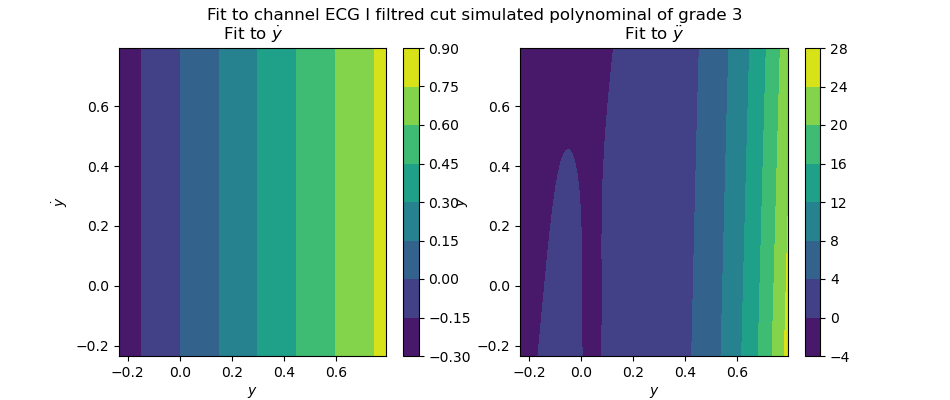

In [136]:
%matplotlib notebook

y = np.linspace(min(series), max(series), 100)
#y = np.linspace(-1, 1, 150)
ydot = y

fig = plt.figure(figsize=(9.5, 4))
fig.suptitle('Fit to channel %s simulated polynominal of grade %i' % (index, grade))

ax_1 = fig.add_subplot(1, 2, 1)
r_1 = [[np.sum(p_1(el, sel)) for sel in ydot] for el in y]
c = ax_1.contourf(y, ydot, r_1)
fig.colorbar(c)
ax_1.set_xlabel('$y$')
ax_1.set_ylabel('$\dot{y}$')
ax_1.set_title('Fit to $\dot{y}$')

ax_2 = fig.add_subplot(1, 2, 2)
r_2 = [[np.sum(p_2(el, sel)) for sel in ydot] for el in y]
c = ax_2.contourf(y, ydot, r_2)
fig.colorbar(c)
ax_2.set_xlabel('$y$')
ax_2.set_ylabel('$\dot{y}$')
ax_2.set_title('Fit to $\ddot{y}$')

plt.show()

<IPython.core.display.Javascript object>


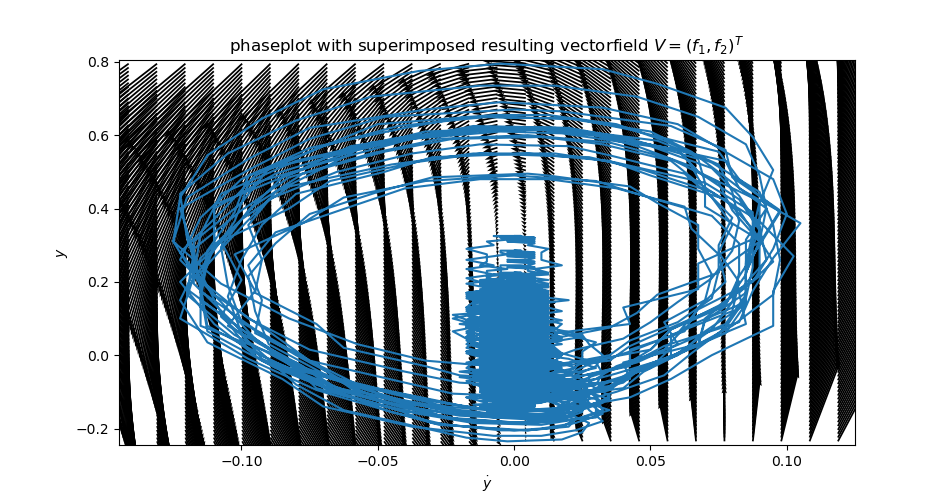

In [137]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5, 5))
plt.plot(five_point_derivate_periodic(series), series)
plt.ylabel('$y$')
plt.xlabel('$\dot{y}$')
plt.title('phaseplot with superimposed resulting vectorfield $V=(f_1,f_2)^T$')
plt.quiver(ydot, y, r_2, r_1, scale=1)
plt.ylim(np.min(series) - 0.01, np.max(series) + 0.01)
plt.xlim(np.min(five_point_derivate_periodic(series)) - 0.02, \
         np.max(five_point_derivate_periodic(series)) + 0.02)
plt.show()

# Solving the resulting ODE
Setting up the system.

Observing that the first coefficient $p_0$ in the resulting ODE is negative - which constitutes a damping $\gamma$:

$$
\dot{y} = y
\\
\ddot{y} = -\omega_0^2 y + \underbrace{p_0 \dot{y} + p_1 y^2 + p_2 y \dot{y} + p_3 \dot{y}^2 + ...}_{=f(y,\dot{y})}
$$

With the above time series the damping equals $2\gamma = p_0 \approx -0.524$:

In [173]:
p_2_[0][0]

-0.5243439000049851

Since having a active damping force, the resulting solution of an ODE system would halt at one point in the pase space. An attempt to avoid this is adding noise to the system. One recalls the Kubo oscillator:

$$
\dot{x} = v
\\
\dot{v} = -(\omega_0^2 + \sqrt{2\gamma}\varepsilon(t)) x + f(x,v)
$$

Where $\varepsilon$ is a gaussian stochastic force with zero mean $<\varepsilon(t)>=0$ to the frequency and $\omega_0$ is the systems mean frequency.

Taking into account that having multiplicative noise in $\dot{v}$ is the same as having additive noise in $\dot{x}$ and using $\sigma = \sqrt{2\gamma}$ to diminish the damping force one can rewrite:

$$
\dot{x} = v + \sigma\varepsilon(t)
\\
\dot{v} = -\omega_0^2 x + f(x,v)
$$

Applying this relation to the ECG system yields

$$
\dot{y} = y + \sigma \Gamma(t)
\\
\ddot{y} = -\omega_0^2 y + \underbrace{p_0 \dot{y} + p_1 y^2 + p_2 y \dot{y} + p_3 \dot{y}^2 + ...}_{=f(y,\dot{y})}
$$

Now one can evaluate for $\sigma = \sqrt{p_0}$:

In [231]:
gamma = abs(p_2_[0][0])
sigma = np.sqrt(gamma) # magnitude of additive noise in y
sigma

0.724115943758308

yielding $\sigma \approx 1.024$. For $\Gamma(t)$ a random function with vanishing mean is used, implemented by ```np.random.normal```. The system can now be set up:

In [245]:
def func_omega_periodic(t, x, fit_to_y, fit_to_ydot):
    ''' ECG common channel system
    '''
    y = [0, 0]

    y[0] = x[1] + sigma * np.random.normal(scale=1.)
    y[1] = fit_to_ydot(x[0], x[1])[0]
    return y

In [243]:
T = len(series)
T = 500 # shorter computation time

ivp = [0, 0]
ivp[0] += series[0]
ivp[1] += five_point_derivate_periodic(series)[0]

sol = solve_ivp(func_omega_periodic, [0, T], [ivp[0], ivp[1]], dense_output=True, args=[p_1, p_2])

t = np.linspace(0, T, T)
y, ydot = sol.sol(t)

res = (t, y, ydot)

<IPython.core.display.Javascript object>


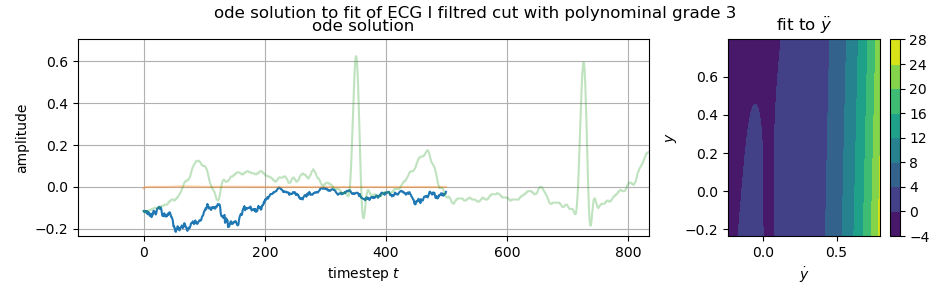

In [244]:
%matplotlib notebook

fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1]}, figsize=(9.5, 3))

max_index = -1
a0.plot(res[0][:max_index], res[1][:max_index], label='$y$')
a0.plot(res[0][:max_index], res[2][:max_index], label='$\dot{y}$', alpha=0.4)
a0.plot(series[:max_index], label='original $y$', alpha=0.3)
a0.set_xlabel('timestep $t$')
a0.set_ylabel('amplitude')
a0.grid()
#a0.legend()
a0.set_title('ode solution')

y_ = np.linspace(min(series), max(series), 100)
ydot_ = y_
#r_2 = [[np.sum(p_2(el, sel)) for sel in ydot_] for el in y_]
c = a1.contourf(y_, ydot_, r_2)
fig.colorbar(c)
a1.set_title('fit to $\ddot{y}$')
a1.set_xlabel('$\dot{y}$')
a1.set_ylabel('$y$')

fig.suptitle('ode solution to fit of %s with polynominal grade %i' % (index, grade))

plt.tight_layout()
plt.show()

# Crosscorrelation of ODE solution and original time series
tba.

In [246]:
o = np.correlate(res[1], series)

<IPython.core.display.Javascript object>


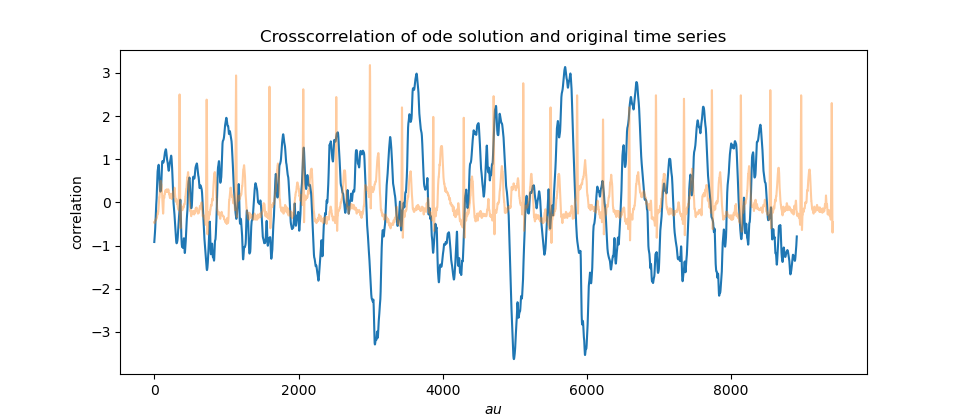

In [247]:
%matplotlib notebook
plt.title('Crosscorrelation of ode solution and original time series')
plt.plot(o)
plt.plot(series * 4, alpha=.4)
plt.xlabel('$\tau$')
plt.ylabel('correlation')
plt.show()

In [149]:
%matplotlib notebook
DEBUG = False
if DEBUG:
    fig = plt.figure(figsize=(9.5, 5))
    plt.plot(res[2], res[1])
    plt.ylabel('$y$')
    plt.xlabel('$\dot{y}$')
    plt.title('phaseplot of ode solution with superimposed resulting vectorfield $V=(f_1,f_2)^T$')
    plt.quiver(ydot, y, r_2, r_1, scale=2)
    plt.ylim(np.min(res[1]) - 0.1, np.max(res[1]) + 0.1)
    plt.xlim(np.min(res[2]) - 0.1, \
             np.max(res[2]) + 0.1)
    plt.show()